# Forecasting with Dynamic Linear Model (DLM)

Among state space models, Dynamic Linear Model (DLM) are one of the most popular models due to its explainability and ability to incorporate regressors with dynamic coefficients. Literature such as Harvey (1989) and Durbin and Koopman (2002) provide a complete review on the models. This notebook introduces a way to construct a vanlia DLM through Pyro and Forecaster modules. In the end, it provides an extension to incorporate flexible coefficients priors.

See also:
- [Forecasting II: state space models](http://pyro.ai/examples/forecasting_ii.html)

#### Workflow 
1. data simulation
2. visualization of coefficients and response
3. Standard DLM training and validation
    - posteriors comparison
    - holdout validation
4. DLM with coefficients priors at various time points
    - posteriors comparison
    - holdout validation

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.contrib.forecast import ForecastingModel, Forecaster, eval_crps
from pyro.infer.reparam import LocScaleReparam
from pyro.ops.stats import quantile

%matplotlib inline
assert pyro.__version__.startswith('1.9.1')

pyro.set_rng_seed(20200928)

pd.set_option('display.max_rows', 500)
plt.style.use('fivethirtyeight')

## Data Simulation

Assume we have observation $y_t$ at time $t$ such that 
$$y_t = x_t^T \beta_t + \epsilon_t$$
$$\beta_t = \beta_{t-1} + \delta_t$$
where

$x_t$ is a P x 1 vector of regressors at time $t$

$\beta_t$ is a P x 1 vector of latent coefficients at time $t$ following a random walk distribution

$\epsilon$ is the noise at time $t$

We then simulate data in following distribution:
$$x_t \sim \mathcal{N}_p(0, \sigma_x^2)$$
$$\delta_t \sim \mathcal{N}_p(0, \sigma_{\delta}^2)$$
$$\epsilon_t \sim \mathcal{N}(0, \sigma_y^2)$$

In [2]:
torch.manual_seed(20200101)
# number of predictors, total observations
p = 5
n = 365 * 3

# start, train end, test end
T0 = 0            
T1 = n - 28
T2 = n

# initializing coefficients at zeros, simulate all coefficient values
beta0 = torch.empty(n, 1).normal_(0, 0.1).cumsum(0)
betas_p = torch.empty(n, p).normal_(0, 0.02).cumsum(0)
betas = torch.cat([beta0, betas_p], dim=-1)

# simulate regressors
covariates = torch.cat(
    [torch.ones(n, 1), torch.randn(n, p) * 0.1],
    dim=-1
)

# observation with noise
y = ((covariates * betas).sum(-1) + 0.1 * torch.randn(n)).unsqueeze(-1)

## Visualization of response and coefficients
Let's take a look on the truth simulated from the previous block.

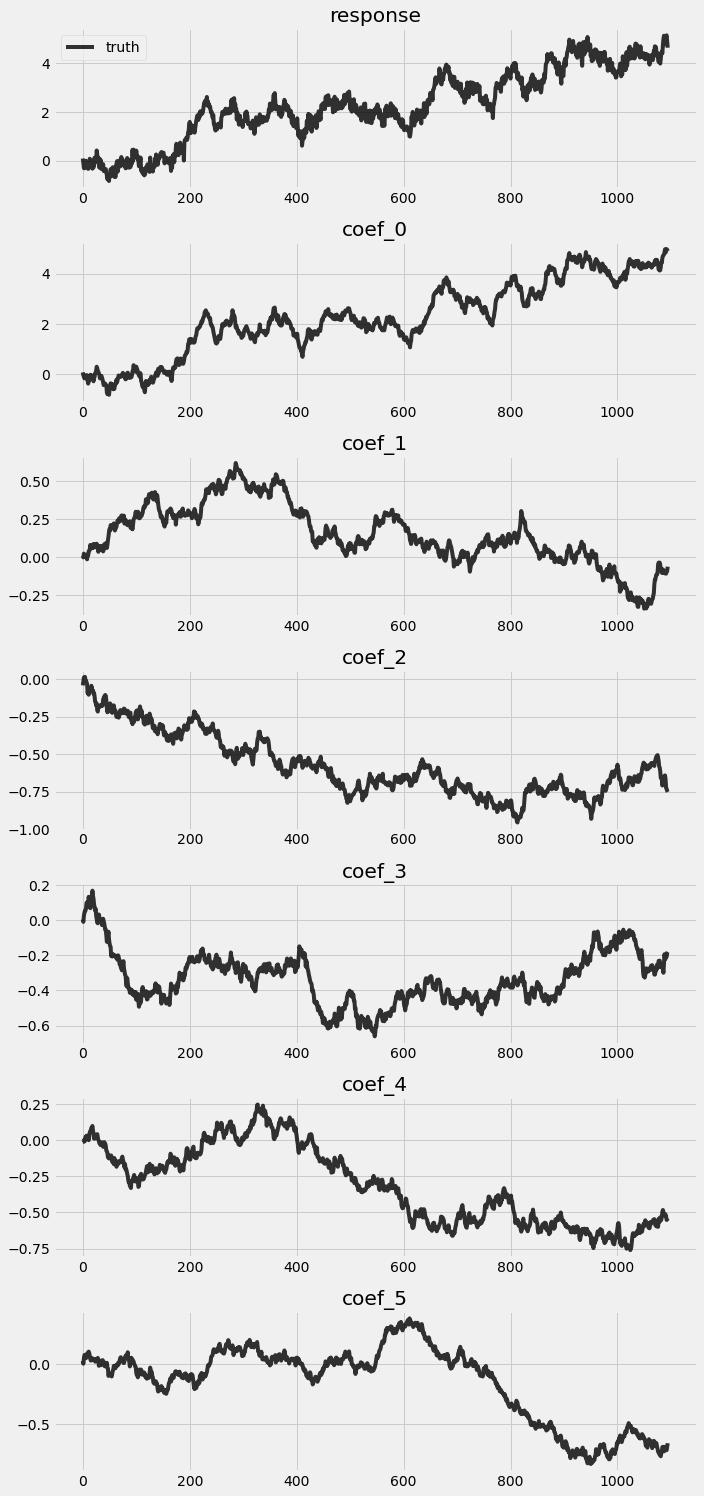

In [3]:
fig, axes = plt.subplots(p + 2, 1, figsize=(10, 3 * (p + 2)))
for idx, ax in enumerate(axes):
    if idx == 0:
        axes[0].plot(y, 'k-', label='truth', alpha=.8)
        axes[0].legend()
        axes[0].set_title('response')
    else:
        axes[idx].plot(betas[:, idx -  1], 'k-', label='truth', alpha=.8)
        axes[idx].set_title('coef_{}'.format(idx - 1))
plt.tight_layout()

## Train and validate a vanilla DLM

Let's build a vanilla DLM following the dynmics we discussed previously.

In [4]:
class DLM(ForecastingModel):
    def model(self, zero_data, covariates):
        data_dim = zero_data.size(-1)
        feature_dim = covariates.size(-1)
        
        drift_scale = pyro.sample("drift_scale", dist.LogNormal(-10, 10).expand([feature_dim]).to_event(1))
        with self.time_plate:
            with poutine.reparam(config={"drift": LocScaleReparam()}):
                drift = pyro.sample("drift", dist.Normal(torch.zeros(covariates.size()), drift_scale).to_event(1))
        
        weight = drift.cumsum(-2)  # A Brownian motion.
        # record in model_trace 
        pyro.deterministic("weight", weight) 

        prediction = (weight * covariates).sum(-1, keepdim=True) 
        assert prediction.shape[-2:] == zero_data.shape
        # record in model_trace 
        pyro.deterministic("prediction", prediction)
        
        scale = pyro.sample("noise_scale", dist.LogNormal(-5, 10).expand([1]).to_event(1))
        noise_dist = dist.Normal(0, scale)
        
        self.predict(noise_dist, prediction)      

In [5]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
model = DLM()
forecaster = Forecaster(
    model, 
    y[:T1], 
    covariates[:T1], 
    learning_rate=0.1, 
    learning_rate_decay=0.05, 
    num_steps=1000,
)

INFO 	 step    0 loss = 7.11372e+10
INFO 	 step  100 loss = 174.352
INFO 	 step  200 loss = 2.06682
INFO 	 step  300 loss = 1.27919
INFO 	 step  400 loss = 1.15015
INFO 	 step  500 loss = 1.34206
INFO 	 step  600 loss = 0.928436
INFO 	 step  700 loss = 1.00953
INFO 	 step  800 loss = 1.04599
INFO 	 step  900 loss = 0.870245


CPU times: user 8.16 s, sys: 39.7 ms, total: 8.2 s
Wall time: 8.22 s


### Posteriors comparison

We extract posteriors during the in-sample period and compare them against the truth.

In [6]:
pyro.set_rng_seed(1)
# record all latent variables in a trace
with poutine.trace() as tr:
    forecaster(y[:T1], covariates[:T1], num_samples=100)

# extract the values from the recorded trace
posterior_samples = {
    name: site["value"]
    for name, site in tr.trace.nodes.items()
    if site["type"] == "sample"
}

We can also visualize the in-sample posteriors.

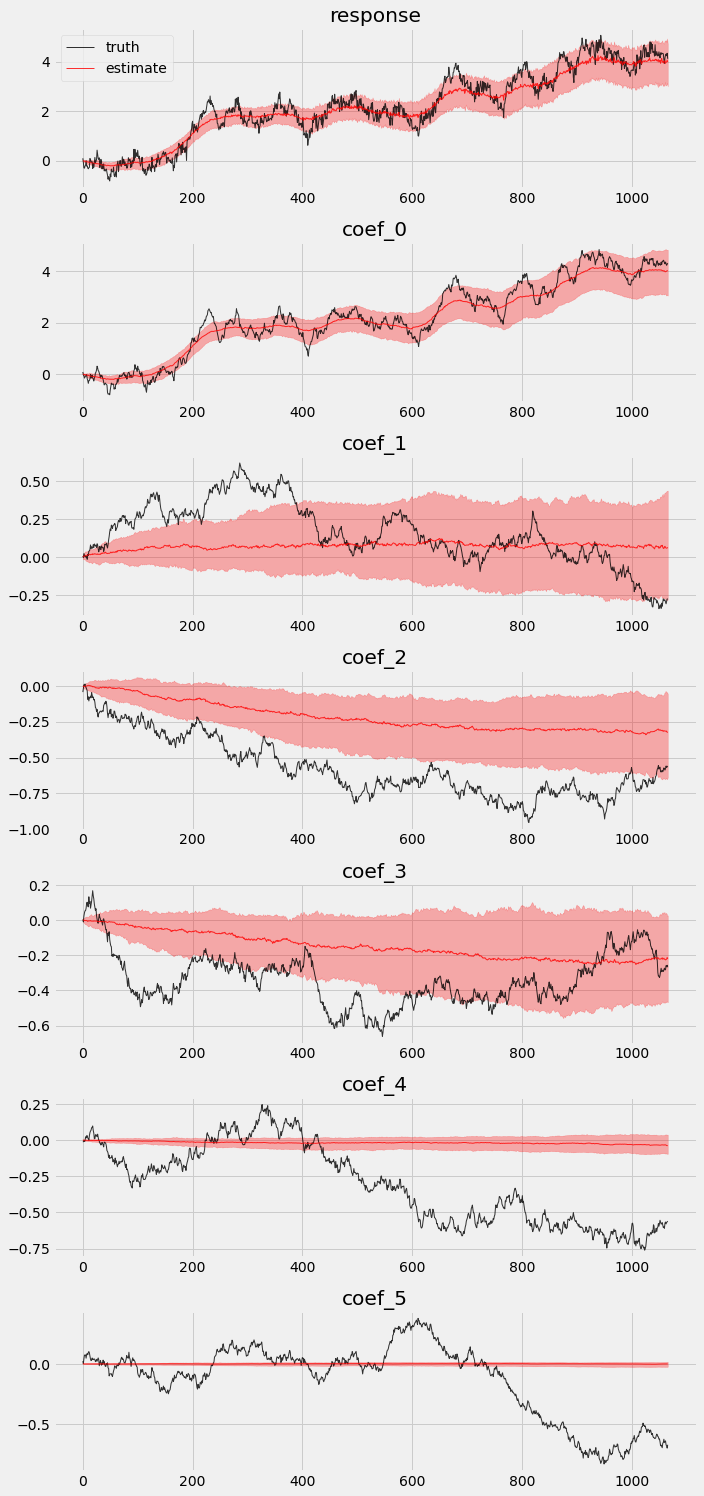

In [7]:
# overlay estimations with truth
fig, axes = plt.subplots(p + 2, 1, figsize=(10, 3 * (p + 2)))
# posterior quantiles of latent variables
pred_p10, pred_p50, pred_p90 = quantile(posterior_samples['prediction'], (0.1, 0.5, 0.9)).squeeze(-1)
# posterior quantiles of latent variables
coef_p10, coef_p50, coef_p90 = quantile(posterior_samples['weight'], (0.1, 0.5, 0.9)).squeeze(-1)

for idx, ax in enumerate(axes):
    if idx == 0:
        axes[0].plot(y[:T1], 'k-', label='truth', alpha=.8, lw=1)
        axes[0].plot(pred_p50, 'r-', label='estimate', alpha=.8, lw=1)
        axes[0].fill_between(torch.arange(0, T1), pred_p10, pred_p90, color="red", alpha=.3)
        axes[0].legend()
        axes[0].set_title('response')
    else:
        axes[idx].plot(betas[:T1, idx -  1], 'k-', label='truth', alpha=.8, lw=1)
        axes[idx].plot(coef_p50[:, idx - 1], 'r-', label='estimate', alpha=.8, lw=1)
        axes[idx].fill_between(torch.arange(0, T1), coef_p10[:, idx-1], coef_p90[:, idx-1], color="red", alpha=.3)
        axes[idx].set_title('coef_{}'.format(idx - 1))
plt.tight_layout()

We can see that not all coefficients can be recovered in the vanilla model.

### Holdout validation
Here, we will visualize the holdout validation for comparison later.

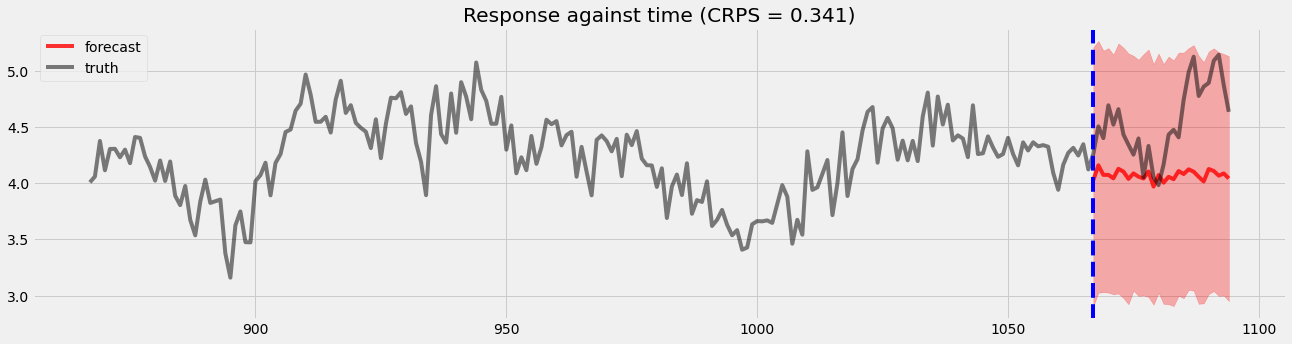

In [8]:
pyro.set_rng_seed(1)
samples = forecaster(y[:T1], covariates, num_samples=1000)
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, y[T1:])

plt.figure(figsize=(20, 5))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast', alpha=.8)
plt.plot(np.arange(T1 - 200, T2), y[T1 - 200:T2], 'k-', label='truth', alpha=.5)
plt.title("Response against time (CRPS = {:0.3g})".format(crps))
plt.axvline(T1, color='b', linestyle='--')
plt.legend(loc="best");

## Train a DLM with coefficients priors at various time points

Sometime user may have prior beliefs of certain coefficients at certain time point. This can be useful in cases where modelers can set an informative prior for those coefficients. For illustration, we create a simple evenly distributed time points and set priors on those points with the known value $B_t$ as such
$$ \beta_t \sim \mathcal{N}_p(B_t, 0.5)$$ where $t \in [t_1, t_2, ... t_n]$ and $[t_1, t_2, ... t_n]$ are the time points we have experiential results.

In [9]:
# let's provide some priors
time_points = np.concatenate((
    np.arange(300, 320),
    np.arange(600, 620),
    np.arange(900, 920),
))
# broadcast on time-points
priors = betas[time_points, 1:]

In [10]:
print(time_points.shape, priors.shape)

(60,) torch.Size([60, 5])


### Model Training
Now, let's construct the new DLM which allows user import coefficents prior at certain time points.

In [11]:
class DLM2(ForecastingModel):
    def model(self, zero_data, covariates):
        data_dim = zero_data.size(-1)
        feature_dim = covariates.size(-1)

        drift_scale = pyro.sample("drift_scale", dist.LogNormal(-10, 10).expand([feature_dim]).to_event(1))
        with self.time_plate:
            with poutine.reparam(config={"drift": LocScaleReparam()}):
                drift = pyro.sample("drift", dist.Normal(torch.zeros(covariates.size()), drift_scale).to_event(1))
        weight = drift.cumsum(-2)  # A Brownian motion.
        # record in model_trace 
        pyro.deterministic("weight", weight)
        
        # This is the only change from the simpler DLM model. 
        # We inject prior terms as if they were likelihoods using pyro observe statements.
        for tp, prior in zip(time_points, priors):
            pyro.sample("weight_prior_{}".format(tp), dist.Normal(prior, 0.5).to_event(1), obs=weight[..., tp:tp+1, 1:]) 

        prediction = (weight * covariates).sum(-1, keepdim=True) 
        assert prediction.shape[-2:] == zero_data.shape
        # record in model_trace 
        pyro.deterministic("prediction", prediction)
        
        scale = pyro.sample("noise_scale", dist.LogNormal(-5, 10).expand([1]).to_event(1))
        noise_dist = dist.Normal(0, scale)
        self.predict(noise_dist, prediction)       

In [12]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
model = DLM2()
forecaster2 = Forecaster(
    model, 
    y[:T1], 
    covariates[:T1], 
    learning_rate=0.1, 
    learning_rate_decay=0.05, 
    num_steps=1000,
)

INFO 	 step    0 loss = 7.11372e+10
INFO 	 step  100 loss = 105.237
INFO 	 step  200 loss = 2.21884
INFO 	 step  300 loss = 1.70493
INFO 	 step  400 loss = 1.64291
INFO 	 step  500 loss = 1.80583
INFO 	 step  600 loss = 0.903905
INFO 	 step  700 loss = 1.25712
INFO 	 step  800 loss = 1.10254
INFO 	 step  900 loss = 0.926691


CPU times: user 36.6 s, sys: 316 ms, total: 36.9 s
Wall time: 37.2 s


### Posterior comparison
Finally, let's redo the exercise we did in previous section to check in-sample posteriors and holdout validation.

In [13]:
pyro.set_rng_seed(1)
with poutine.trace() as tr:
    forecaster2(y[:T1], covariates[:T1], num_samples=100)

posterior_samples2 = {
    name: site["value"]
    for name, site in tr.trace.nodes.items()
    if site["type"] == "sample"
}

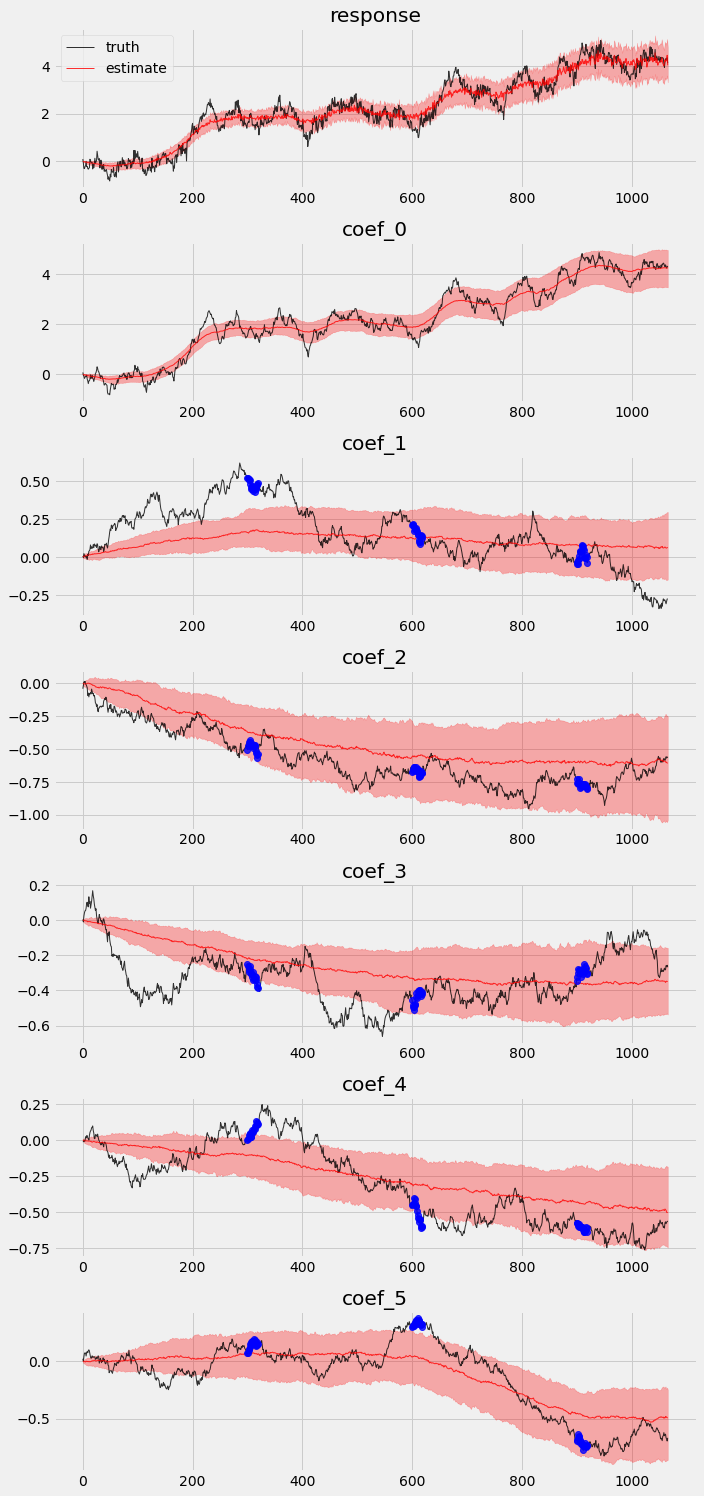

In [14]:
# overlay estimations with truth
fig, axes = plt.subplots(p + 2, 1, figsize=(10, 3 * (p + 2)))
# posterior quantiles of latent variables
pred_p10, pred_p50, pred_p90 = quantile(posterior_samples2['prediction'], (0.1, 0.5, 0.9)).squeeze(-1)
# posterior quantiles of latent variables
coef_p10, coef_p50, coef_p90 = quantile(posterior_samples2['weight'], (0.1, 0.5, 0.9)).squeeze(-1)

for idx, ax in enumerate(axes):
    if idx == 0:
        axes[0].plot(y[:T1], 'k-', label='truth', alpha=.8, lw=1)
        axes[0].plot(pred_p50, 'r-', label='estimate', alpha=.8, lw=1)
        axes[0].fill_between(torch.arange(0, T1), pred_p10, pred_p90, color="red", alpha=.3)
        axes[0].legend()
        axes[0].set_title('response')
    else:
        axes[idx].plot(betas[:T1, idx - 1], 'k-', label='truth', alpha=.8, lw=1)
        axes[idx].plot(coef_p50[:, idx - 1], 'r-', label='estimate', alpha=.8, lw=1)
        if idx >= 2:
            axes[idx].plot(time_points, priors[:, idx-2], 'o', color='blue', alpha=.8, lw=1)
        axes[idx].fill_between(torch.arange(0, T1), coef_p10[:, idx-1], coef_p90[:, idx-1], color="red", alpha=.3)
        axes[idx].set_title('coef_{}'.format(idx - 1))
plt.tight_layout()

### Holdout validation

torch.Size([1000, 28, 1]) torch.Size([28])


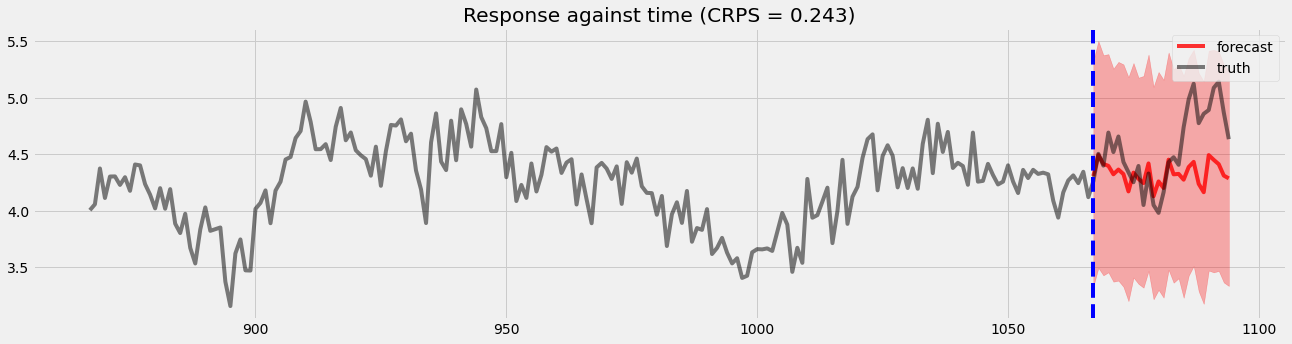

In [15]:
pyro.set_rng_seed(1)
samples2 = forecaster2(y[:T1], covariates, num_samples=1000)
p10, p50, p90 = quantile(samples2, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples2, y[T1:])
print(samples2.shape, p10.shape)

plt.figure(figsize=(20, 5))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast', alpha=.8)
plt.plot(np.arange(T1 - 200, T2), y[T1 - 200:T2], 'k-', label='truth', alpha=.5)
plt.title("Response against time (CRPS = {:0.3g})".format(crps))
plt.axvline(T1, color='b', linestyle='--')
plt.legend(loc="best");

We can see there is an obvious improvement in both coefficients movement detection and holoud validation.

## Conclusion

1. We show how to create a classic DLM with Pyro that provides decent forecast result.
2. With priors injection, we improve the model in getting more accurate coefficients and predictions.

## Reference
1. Harvey, C. A. (1989). *Forecasting, Structural Time Series and the Kalman Filter*, Cambridge University Press.
2. Durbin, J., Koopman, S. J.. (2001). *Time Series Analysis by State Space Methods*, Oxford Statistical Science Series
3. Scott, S. L., and Varian, H. (2015). "Inferring Causal Impact using Bayesian Structural Time-Series Models" The Annals of Applied Statistics, 9(1), 247–274.
4. Moore, D., Burnim, J, and the TFP Team (2019). "Structural Time Series modeling in TensorFlow Probability" Available at [https://blog.tensorflow.org/2019/03/structural-time-series-modeling-in.html](https://blog.tensorflow.org/2019/03/structural-time-series-modeling-in.html)